In [14]:
import IPython.display as ipd
import numpy as np
import re

## load fastspeech related packages
import sys
import torch
sys.path.insert(1, '/mnt/gyzhang/fastspeech2-master/')
# from modules.ser import SER
from tasks.ser import SERTask,EmoDataset
from utils.hparams import hparams, set_hparams

## load ganvocoder related packages
import os
import json
from scipy import signal
from scipy.io.wavfile import write


## load matplot packages
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

from sklearn.manifold import TSNE
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 8)

import glob
import umap
import pickle
from sklearn.model_selection import train_test_split

import torch.nn as nn
from torch.utils.data import Dataset
import random
from torch.utils.data import DataLoader

from tensorboardX import SummaryWriter
from tqdm import tqdm
import torch.nn.functional as F
from scipy.special import softmax

## load fastspeech related packages
import sys
import torch
sys.path.insert(1, '/mnt/gyzhang/projects/fastspeech2-master/')
from modules.fs2 import FastSpeech2
from tasks.fs2 import FastSpeech2Task,FastSpeechTestDataset
from utils.hparams import hparams, set_hparams



### Load Train Emotion and Cached Files


In [2]:
emo2id = {'sad':0, 'neutral':1, 'happy':2, 'angry':3}

cached_path = "/mnt/gyzhang/projects/fastspeech2-master/checkpoints/tgemotion_neutral_semi_2/test_generated_271000__"
emo_embed_files = glob.glob(f"{cached_path}/emo_embed/*.npy")
emo_logits_files = glob.glob(f"{cached_path}/emo_logits/*.npy")
gen_emo_logits_files= glob.glob(f"{cached_path}/gen_emo_logits/*.npy")

In [4]:
# random the emo_logit
random.shuffle(emo_logits_files)

In [5]:
id2probs = {0:[], 1:[], 2:[], 3:[]}
id2emoprobs = {0:[], 1:[], 2:[], 3:[]}
id2neuprobs = {0:[], 1:[], 2:[], 3:[]}

id211probs = {0:[], 1:[], 2:[], 3:[]}
id211emoprobs = {0:[], 1:[], 2:[], 3:[]}
id211neuprobs = {0:[], 1:[], 2:[], 3:[]}

ood2emoid = {'TGGYY':{i:0 for i in emo2id.values()}, 'TGLX':{i:0 for i in emo2id.values()}, 'TGLF':{i:0 for i in emo2id.values()}} # the ood item's 

emo_count=0

for emo_logits_file in emo_logits_files:
    spk_fn, emo, _ = re.split("\_", os.path.basename(emo_logits_file))  
    emo_logit = np.load(emo_logits_file)
    emo_11 = np.power(2, emo_logit)/np.sum(np.power(2, emo_logit))
    emo_softmax = softmax(emo_logit)
    k = np.argmax(emo_logit)
    
    k_prob = emo_softmax[k]
    id2probs[k].append(k_prob)
    
    k_11prob = emo_11[k]
    id211probs[k].append(k_11prob)
    
    if emo in emo2id.keys():
        id2emoprobs[k].append(k_prob)
        id211emoprobs[k].append(k_11prob)
    else:
        id2neuprobs[k].append(k_prob)
        id211neuprobs[k].append(k_11prob)
        ood2emoid[spk_fn][k]+=1
        
    

/tmp/ipykernel_8227/1058157357.py:16: RuntimeWarning: overflow encountered in power
  emo_11 = np.power(2, emo_logit)/np.sum(np.power(2, emo_logit))
/tmp/ipykernel_8227/1058157357.py:16: RuntimeWarning: invalid value encountered in true_divide
  emo_11 = np.power(2, emo_logit)/np.sum(np.power(2, emo_logit))


In [6]:
emo2id

{'sad': 0, 'neutral': 1, 'happy': 2, 'angry': 3}

In [7]:
fig, axes = plt.subplots(1, len(emo2id.keys()), figsize=(16, 4))
fig.suptitle(r'$\alpha = 2 $')
for emo, i in emo2id.items():
    axes[i].hist(id211emoprobs[i], color = 'black', range = (0,1), edgecolor = 'black',
         bins = 128)
    plt.setp(axes[i], xlabel=f'Emotion intensity ({emo})')

plt.setp(axes[0], ylabel='Number of utterances')



[Text(0, 0.5, 'Number of utterances')]

In [8]:
fig, axes = plt.subplots(1, len(emo2id.keys()), figsize=(16, 4))
fig.suptitle(r'$\alpha = 2 $')
for emo, i in emo2id.items():
    axes[i].hist(id211neuprobs[i], color = 'black', range = (0,1),edgecolor = 'black',
         bins = 128)
    plt.setp(axes[i], xlabel=f'Emotion intensity ({emo})')
plt.setp(axes[0], ylabel='Number of utterances')


[Text(0, 0.5, 'Number of utterances')]

#### The OOD Speakers and Their Emotion ID


In [22]:
spk_map = {'TGGYY':61, 'TGLX':62, 'TGLF':63}
spk_count = {'INDOMAIN':0,'TGGYY':0, 'TGLX':0, 'TGLF':0}
np_arrs = []
spk_list = []
emo_list = []


for np_file in emo_logits_files:
    spk_fn, emo_fn,_ = re.split("\_", os.path.basename(np_file))
    if spk_fn in spk_map.keys():
        if spk_count[spk_fn] < 100:
            spk_count[spk_fn] += 1
            spk_list.append(spk_map[spk_fn])
            emo_list.append('TBF')
            np_arr = np.squeeze(np.load(np_file))
            np_arrs.append(np_arr)
    else:
        if spk_count['INDOMAIN'] <= 400:
            spk_count['INDOMAIN'] += 1
            spk_list.append(60)
            emo_list.append(emo_fn)
            np_arr = np.squeeze(np.load(np_file))
            np_arrs.append(np_arr)
            
        

reducer = umap.UMAP()
hidden_features = np.stack(np_arrs)
hidden_features = np.asarray(hidden_features, dtype='float64')
X_embedded = reducer.fit_transform(hidden_features)

<AxesSubplot:>

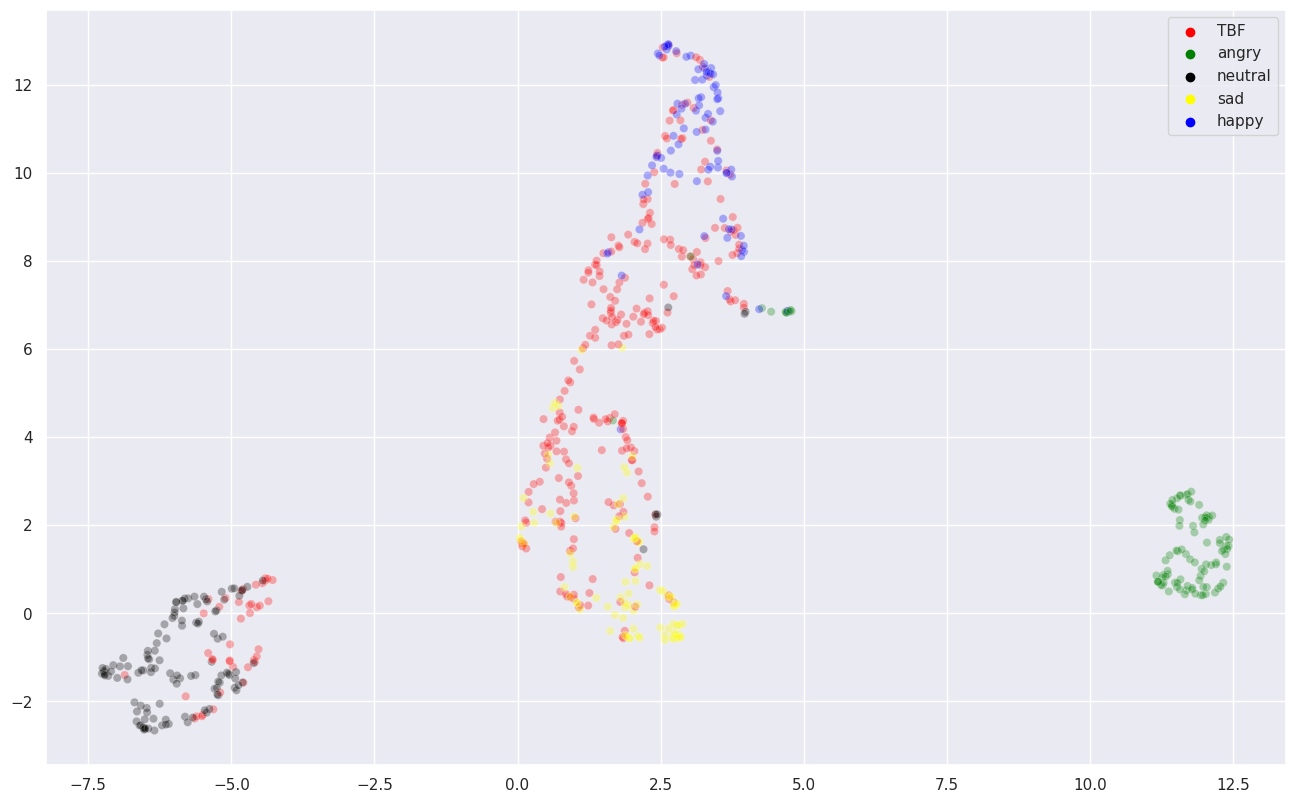

In [24]:
y=np.array(emo_list)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X_embedded[:,0], y=X_embedded[:,1],
    hue=y,
    palette=['red', 'green', 'black','yellow', 'blue'],
    legend="full",
    alpha=0.3
)

In [20]:
spk_map = {'TGGYY':61, 'TGLX':62, 'TGLF':63}
spk_count = {'INDOMAIN':0,'TGGYY':0, 'TGLX':0, 'TGLF':0}
np_arrs = []
spk_list = []
emo_list = []


for np_file in emo_embed_files:
    spk_fn, emo_fn,_ = re.split("\_", os.path.basename(np_file))
    if spk_fn in spk_map.keys():
        if spk_count[spk_fn] < 100:
            spk_count[spk_fn] += 1
            spk_list.append(spk_map[spk_fn])
            emo_list.append('TBF')
            np_arr = np.squeeze(np.load(np_file))
            np_arrs.append(np_arr)
    else:
        if spk_count['INDOMAIN'] <= 400:
            spk_count['INDOMAIN'] += 1
            spk_list.append(60)
            emo_list.append(emo_fn)
            np_arr = np.squeeze(np.load(np_file))
            np_arrs.append(np_arr)
            
        

reducer = umap.UMAP()
hidden_features = np.stack(np_arrs)
hidden_features = np.asarray(hidden_features, dtype='float64')
X_embedded = reducer.fit_transform(hidden_features)

In [19]:
spk_count['TGGYY']

100

<AxesSubplot:>

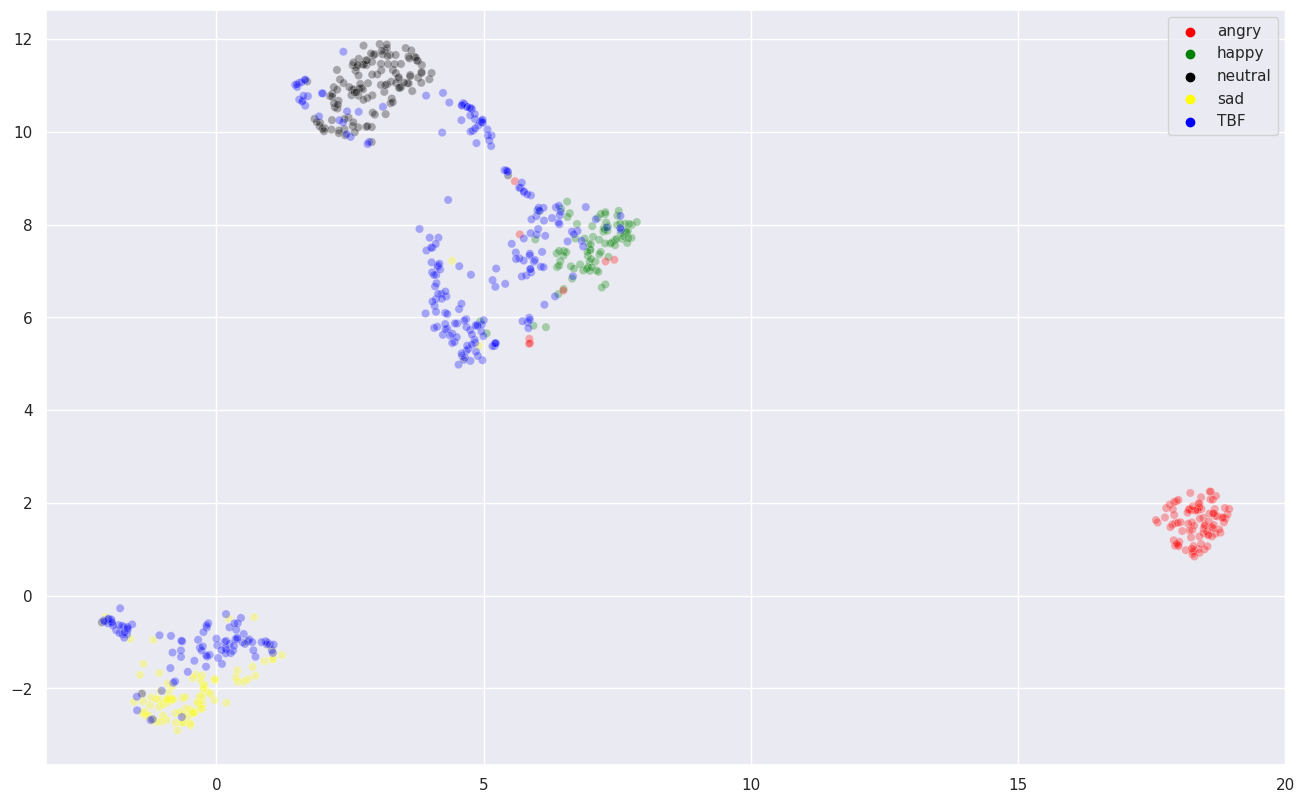

In [21]:
y=np.array(emo_list)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X_embedded[:,0], y=X_embedded[:,1],
    hue=y,
    palette=['red', 'green', 'black','yellow', 'blue'],
    legend="full",
    alpha=0.3
)

<AxesSubplot:>

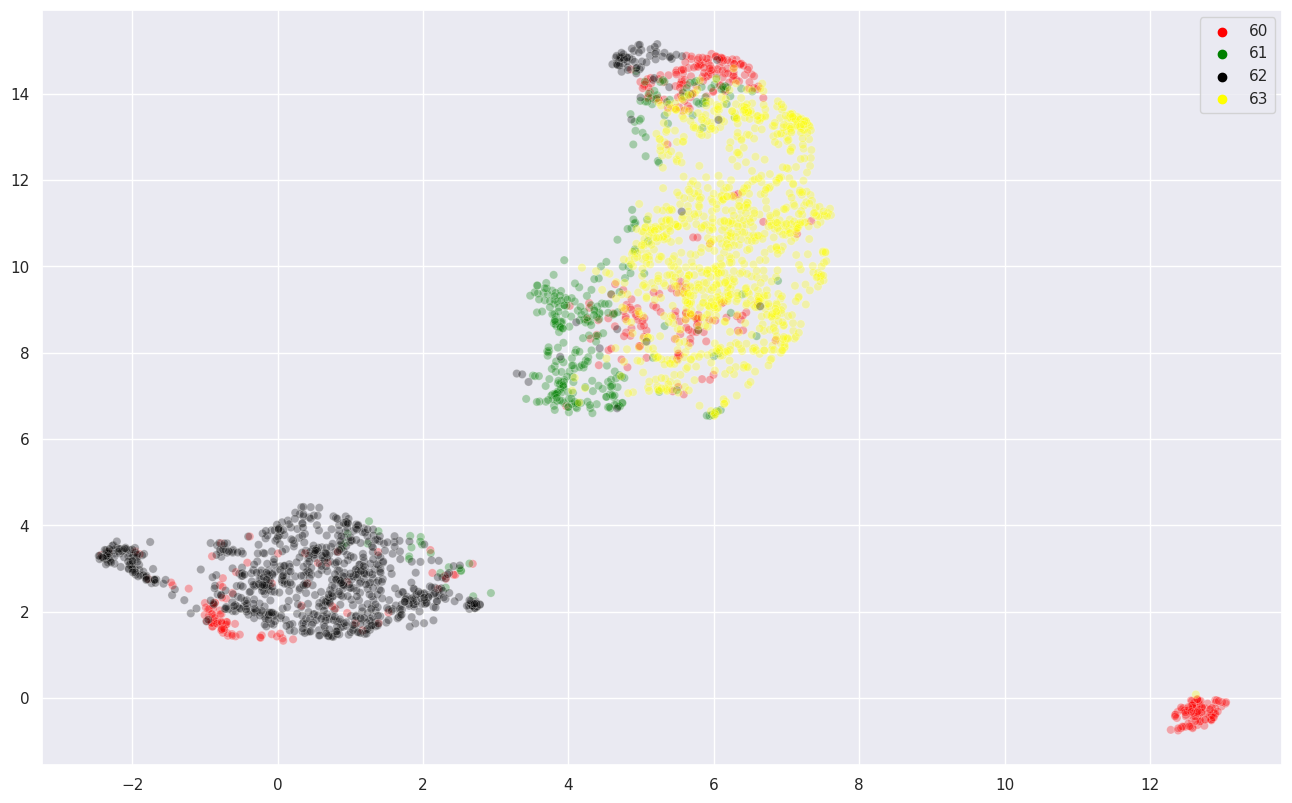

In [121]:
y=np.array(spk_list,np.int32)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X_embedded[:,0], y=X_embedded[:,1],
    hue=y,
    palette=['red', 'green', 'black','yellow'],
    legend="full",
    alpha=0.3
)

### Load Emotion Logits (Test) and Cached File

In [2]:
in_spk_list = os.listdir('/mnt/gyzhang/fastspeech2-master/data/raw/TGEmotion/mfa_input')
spk2id = {spk:idx+1 for idx, spk in enumerate(in_spk_list)}

spk_list = ['TGLF_20210719', 'TGGYY_20210621', 'TGLX_20210719']
spk2id.update({spk.split("_")[0]:idx+61 for idx, spk in enumerate(spk_list)})


In [57]:
emo2id = {'sad':0, 'neutral':1, 'happy':2, 'angry':3}
cached_path = "/mnt/gyzhang/projects/fastspeech2-master/checkpoints/tgemotion_neutral_semi_2/test_generated_271000__"

emo_embed_files = glob.glob(f"{cached_path}/emo_embed/*.npy")
emo_logits_files = glob.glob(f"{cached_path}/emo_logits/*.npy")
gen_emo_logits_files = glob.glob(f"{cached_path}/gen_emo_logits/*.npy")

### Emotion Recognition Accuracy

In [ ]:
corr_num = 0
total_num = 0

for emo_logits_file in emo_logits_files:
    emo_fn = re.split("\_", os.path.basename(emo_logits_file))[1]
    
    if emo_fn in emo2id:
        emo_id = emo2id[emo_fn]
        corr_num += (np.argmax(np.load(emo_logits_file)) == emo_id)
        total_num += 1
print(f"Acc {corr_num/total_num}")

In [ ]:
corr_num = 0
total_num = 0

for emo_logits_file in gen_emo_logits_files:
    emo_fn = re.split("\_", os.path.basename(emo_logits_file))[1]
    
    if emo_fn in emo2id:
        emo_id = emo2id[emo_fn]
        corr_num += (np.argmax(np.load(emo_logits_file)) == emo_id)
        total_num += 1
print(f"Acc {corr_num/total_num}")

In [ ]:
hidden_features = []
emo_ids = []

for hidden_file in hidden_files:
    emo_fn = re.split("\_", os.path.basename(hidden_file))[1]
    emo_ids.append(emo_fn)
    hidden_np = np.squeeze(np.load(hidden_file))
    hidden_features.append(hidden_np)

### Save the Average Embedding for Sentence with N Highest Probabilities for Each Emotion

In [62]:
N=20

In [64]:
emo2vecs = {'sad':[], 'neutral':[], 'happy':[], 'angry':[]}
emo2toppros = {'sad':[], 'neutral':[], 'happy':[], 'angry':[]}
emo_fns = []

for emo_embed_file in emo_embed_files:
    emo_basename = os.path.basename(emo_embed_file)
    emo_logit_path = f"{cached_path}/emo_logits/{emo_basename}"
    emo_logit = np.load(emo_logit_path)
    emo_11 = np.power(1.05, emo_logit)/np.sum(np.power(1.05, emo_logit))
    emo_fn = re.split("\_", emo_basename)[1]
    if emo_fn not in emo2id:
        continue
    emo_id = emo2id[emo_fn]
    emo_prob = emo_11[emo_id]
    
    emo_fns.append(emo_fn)
    curr_probs = emo2toppros[emo_fn]
    hidden_np = np.squeeze(np.load(emo_embed_file))
    
    
    if len(curr_probs) < 20:
        curr_probs.append(emo_prob)
        emo2vecs[emo_fn].append(hidden_np)
    else:
        if emo_prob > min(curr_probs):
            min_idx = np.argmin(curr_probs)
            curr_probs[min_idx] = emo_prob
            emo2vecs[emo_fn][min_idx] = hidden_np

        
emo2mean = {emo:np.mean(np.stack(vecs),axis=0) for emo, vecs in emo2vecs.items()}
emoid2mean = {emo2id[emo]:vec for emo, vec in emo2mean.items()}

with open(f"{cached_path}/top{N}_emoid2vec" + '.pkl', 'wb') as f:
    pickle.dump(emoid2mean, f, pickle.HIGHEST_PROTOCOL)

In [66]:
f"{cached_path}/top{N}_emoid2vec" + '.pkl'

'/mnt/gyzhang/projects/fastspeech2-master/checkpoints/tgemotion_neutral_semi_2/test_generated_271000__/top20_emoid2vec.pkl'

In [ ]:
reducer = umap.UMAP()

In [ ]:
hidden_features = np.stack(hidden_features)
hidden_features = np.asarray(hidden_features, dtype='float64')
X_embedded = reducer.fit_transform(hidden_features)

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X_embedded[:,0], y=X_embedded[:,1],
    hue=emo_ids,
    palette=['red', 'green', 'black', 'yellow'],
    legend="full",
    alpha=0.3
)

### Compute the Mutual Information with Text

In [6]:
train_cached_path = "/mnt/gyzhang/projects/fastspeech2-master/checkpoints/tgemotion_neutral_semi_2/train_generated_271000__"
trained_text_embed_files = glob.glob(f"{train_cached_path}/text_embed/*.npy")
trained_emo_embed_files = glob.glob(f"{train_cached_path}/emo_embed/*.npy")

In [7]:
train_text_files, valid_text_files, train_emo_files, valid_emo_files = train_test_split(trained_text_embed_files, trained_emo_embed_files, test_size=0.2, shuffle=True)

train_list = []
for train_text_file in train_text_files:
    with open(train_text_file) as fh:
        text_embed = np.squeeze(np.load(train_text_file))
    train_list.append(text_embed)
train_text_mean = np.mean(train_list, axis=0)
train_text_std = np.std(train_list, axis=0)


train_list = []
for train_emo_file in train_emo_files:
    with open(train_emo_file) as fh:
        emo_embed = np.squeeze(np.load(train_emo_file))
    train_list.append(emo_embed)
train_emo_mean = np.mean(train_list, axis=0)
train_emo_std = np.std(train_list, axis=0)




In [3]:
class MyDataset(Dataset):
    def __init__(self, text_files, emo_files):
        self.text_files = text_files
        self.emo_files = emo_files
    
    def __len__(self):
        return len(self.text_files)

    def __getitem__(self, idx):
        text_file_path = self.text_files[idx]
        emo_file_path = self.emo_files[idx]
        
 
        emo_embed = np.squeeze(np.load(emo_file_path))
        text_embed = np.squeeze(np.load(text_file_path))
        
        return {'text_embed':text_embed, 'emo_embed':emo_embed}
    
    def collate_fn(self, batch):
        emo_embeddings = np.stack([d['emo_embed'] for d in batch])
        emo_embeddings = (emo_embeddings - train_emo_mean) / train_emo_std
        emo_embeddings = torch.FloatTensor(emo_embeddings)
    
        text_embeddings = np.stack([d['text_embed'] for d in batch])
        text_embeddings = (text_embeddings - train_text_mean) / train_text_std
        text_embeddings = torch.FloatTensor(text_embeddings)
        
        indices = torch.randperm(text_embeddings.shape[0])
        text_embeddings_permutation = text_embeddings[indices,:]

    
        return emo_embeddings, text_embeddings, text_embeddings_permutation

In [4]:
N2=64

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(512, N2)
        self.bn1 = nn.BatchNorm1d(num_features=N2)
        self.fc2 = nn.Linear(N2, N2)
        self.bn2 = nn.BatchNorm1d(num_features=N2)
        self.fc5 = nn.Linear(N2, 1)

    def forward(self, x, y):
        xy = torch.cat((x, y), 1)
        h1 = F.relu(self.bn1(self.fc1(xy)))
        h2 = F.relu(self.bn2(self.fc2(h1)))
        h5 = self.fc5(h2)
        return h5

In [8]:
train_dataset = MyDataset(text_files=train_text_files, emo_files=train_emo_files)
valid_dataset = MyDataset(text_files=valid_text_files, emo_files=valid_emo_files)

train_loader = DataLoader(
            train_dataset,
            batch_size=512,
            shuffle=True,
            collate_fn=train_dataset.collate_fn,
            drop_last=False,
            pin_memory=False)

valid_loader = DataLoader(
            valid_dataset,
            batch_size=512,
            shuffle=True,
            collate_fn=valid_dataset.collate_fn,
            drop_last=False,
            pin_memory=False)

model = Net().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
plot_loss = []

In [9]:
exp_name = "tgemotion_neutral_semi_2"
mi_name = "text"

sw = SummaryWriter(f"/mnt/gyzhang/log-outdir-mi/{exp_name}-{mi_name}-2")

In [ ]:
n_epoch = 1000

for epoch in tqdm(range(n_epoch)):
    epoch_loss = []
    for train_batch in train_loader:
        x, y, y_permu = train_batch
        model.zero_grad()
        x = x.cuda()
        y = y.cuda()
        y_permu = y_permu.cuda()
        pred_xy = model(x, y)
        pred_x_y = model(x, y_permu)
        ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        loss = - ret  # maximize
        epoch_loss.append(ret.cpu().data.item())
        model.zero_grad()
        loss.backward()
        optimizer.step()  
    sw.add_scalar('epoch_loss', torch.Tensor(np.array(np.mean(epoch_loss))), epoch + 1)
    
    model.eval()
    val_epoch_loss = []
    for test_batch in valid_loader:
        x, y, y_permu = test_batch
        x = x.cuda()
        y = y.cuda()
        y_permu = y_permu.cuda()
        pred_xy = model(x, y)
        pred_x_y = model(x, y_permu)
        ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        val_epoch_loss.append(ret.cpu().data.item())
    sw.add_scalar('val_epoch_loss', torch.Tensor(np.array(np.mean(val_epoch_loss))), epoch + 1)
    model.train()

  3%|▎         | 26/1000 [1:03:20<39:34:59, 146.30s/it]

### Compute the Mutual Information Between Speaker and Emotion

In [ ]:
num_emo = 4 
num_spk = 70
use_emo = False

In [ ]:
test_cached_path = "/mnt/gyzhang/projects/fastspeech2-master/checkpoints/tgemotion_neutral_semi_2/test_generated_271000_"
train_cached_path = "/mnt/gyzhang/projects/fastspeech2-master/checkpoints/tgemotion_neutral_semi_2/train_generated_271000_"

trained_emo_embed_files = glob.glob(f"{train_cached_path}/emo_embed/*.npy")
test_emo_embed_files = glob.glob(f"{test_cached_path}/emo_embed/*.npy")

### Compute the Mutual Information Between Embedding and Emotion

In [ ]:
in_trained_emo_embed_files = []
out_trained_emo_embed_files = []
in_test_emo_embed_files = []
out_test_emo_embed_files = []

for emo_embed_file in trained_emo_embed_files:
    spk, emo, _ = re.split("\_", os.path.basename(emo_embed_file))
    if emo in emo2id:
        in_trained_emo_embed_files.append(emo_embed_file)
    else:
        out_trained_emo_embed_files.append(emo_embed_file)
        
for emo_embed_file in test_emo_embed_files:
    spk, emo, _ = re.split("\_", os.path.basename(emo_embed_file))
    if emo in emo2id:
        in_test_emo_embed_files.append(emo_embed_file)
    else:
        out_test_emo_embed_files.append(emo_embed_file)
        

In [ ]:
if use_emo:
    train_files, valid_files = train_test_split(in_trained_emo_embed_files, test_size=0.2, shuffle=True)
else:
    train_files, valid_files = train_test_split(trained_emo_embed_files, test_size=0.2, shuffle=True)

train_list = []
for train_file in train_files:
    with open(train_file) as fh:
        emo_embed = np.squeeze(np.load(train_file))
    train_list.append(emo_embed)
train_mean = np.mean(train_list, axis=0)
train_std = np.std(train_list, axis=0)

In [ ]:
N=32
N2=16
N3=8
D=4 if use_emo else 70

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fcx = nn.Linear(256, N2)
        self.fcy = nn.Linear(D, N2)
        self.fc2 = nn.Linear(N2, N2)
        self.fc5 = nn.Linear(N2, 1)

    def forward(self, x, y):
        hx1 = F.relu(self.fcx(x))
        hy1 = F.relu(self.fcy(y))
        h1 = hx1 + hy1
        h2 = F.relu(self.fc2(h1))
        h2 = h1 + h2
        h5 = self.fc5(h2)
        return h5

In [ ]:
class MyDataset(Dataset):
    def __init__(self, files):
        self.files = files
        random.seed(1234)
        random.shuffle(self.files)

        self.id_name = "emo_id" if use_emo else "spk_id"
        self.d_num = 4 if use_emo else 70
        
        
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        spk, emo, _ = re.split("\_", os.path.basename(file_path))
        
        if use_emo:
            rid = emo2id[emo]
        else:
            rid = spk2id[spk]
            
        emo_embed = np.squeeze(np.load(file_path))
        
        return {self.id_name:rid, 'emo_embed':emo_embed}
    
    def collate_fn(self, batch):
        embeddings = np.stack([d['emo_embed'] for d in batch])
        embeddings = (embeddings - train_mean) / train_std
        embeddings = torch.FloatTensor(embeddings)
        ids = [d[self.id_name] for d in batch] #[3,4,5]
        ids_permutation = np.random.permutation(ids)
        ids = torch.FloatTensor(np.eye(self.d_num)[ids])
        ids_permutation = torch.FloatTensor(np.eye(self.d_num)[ids_permutation])
        return embeddings, ids, ids_permutation

In [ ]:
train_dataset = MyDataset(files=train_files)
valid_dataset = MyDataset(files=valid_files)

train_loader = DataLoader(
            train_dataset,
            batch_size=512,
            shuffle=True,
            collate_fn=train_dataset.collate_fn,
            drop_last=False,
            pin_memory=False)

valid_loader = DataLoader(
            valid_dataset,
            batch_size=512,
            shuffle=True,
            collate_fn=valid_dataset.collate_fn,
            drop_last=False,
            pin_memory=False)

model = Net().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
plot_loss = []


In [ ]:
exp_name = "tgemotion_neutral_semi_2"
mi_name = "spk"

sw = SummaryWriter(f"/mnt/gyzhang/log-outdir-mi/{exp_name}-{mi_name}")


In [ ]:
n_epoch = 1000

for epoch in tqdm(range(n_epoch)):
    epoch_loss = []
    for train_batch in train_loader:
        x, y, y_permu = train_batch
        model.zero_grad()
        x = x.cuda()
        y = y.cuda()
        y_permu = y_permu.cuda()
        pred_xy = model(x, y)
        pred_x_y = model(x, y_permu)
        ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        loss = - ret  # maximize
        epoch_loss.append(-loss.cpu().data.item())
        model.zero_grad()
        loss.backward()
        optimizer.step()
    sw.add_scalar('epoch_loss', torch.Tensor(np.array(np.mean(epoch_loss))), epoch + 1)
    model.eval()
    val_epoch_loss = []
    for test_batch in valid_loader:
        x, y, y_permu = test_batch
        x = x.cuda()
        y = y.cuda()
        y_permu = y_permu.cuda()
        pred_xy = model(x, y)
        pred_x_y = model(x, y_permu)
        ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        val_epoch_loss.append(ret.cpu().data.item())
    sw.add_scalar('val_epoch_loss', torch.Tensor(np.array(np.mean(val_epoch_loss))), epoch + 1)
    model.train()

#### Test Files 

In [ ]:
test_dataset = MyDataset(files=in_test_emo_embed_files)

In [ ]:
test_embeddings, test_ids, test_ids_permutation = test_dataset.collate_fn(test_dataset)

In [ ]:
x = test_embeddings.cuda()
y = test_ids.cuda()
y_permu = test_ids_permutation.cuda()
pred_xy = model(x, y)
pred_x_y = model(x, y_permu)
ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))

### Load Gan Vocoder configuration

In [ ]:
# GYY
# v_checkpoint_file = "/mnt/ttsdata/tts_exp_traning_log/TGGYY_all_dev_16k_mb_melgan_256_20210918_210123_28739/g_00250000"
# v_checkpoint_file = "/mnt/ttsdata/tts_exp_traning_log/TGLF_all_dev_16k_mb_melgan_256_20210919_143939_28508/g_00540000"
v_checkpoint_file = "/mnt/ttsdata/tts_exp_traning_log/TGEmotionalChild_all_dev_16k_mb_melgan_256_20211101_160156_7784/g_01190000"

config_file = os.path.join(os.path.split(v_checkpoint_file)[0], 'config.json')

global h
with open(config_file) as f:
    data = f.read()
json_config = json.loads(data)
h = AttrDict(json_config)
torch.manual_seed(h.seed)
global device
if torch.cuda.is_available():
    torch.cuda.manual_seed(h.seed)
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
def load_checkpoint(filepath, device):
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict

generator = MelGANGeneratorV1(
                out_channels=h.output_channel,
                channels=h.upsample_initial_channel,
                upsample_scales=h.upsample_rates,
                use_weight_norm=True,
                #stacks = 2,
            ).to(device)

state_dict_g = load_checkpoint(v_checkpoint_file, device)
generator.load_state_dict(state_dict_g['generator'])
generator.eval()
generator.remove_weight_norm()

pqmf = PQMF(h.output_channel).to(device)

**Load configuration and corresponding checkpoint for the fastspeech2**

In [16]:
config_file = "/mnt/gyzhang/projects/fastspeech2-master/configs/tts/TGEmotion/fs2j_semi.yaml"
exp_name = "tgemotion_neutral_semi_2"
set_hparams(use_cmd=False, config=config_file, exp_name=exp_name)
hparams['data_dir'] = "/mnt/gyzhang/projects/fastspeech2-master/data/tgemotion_neutral"
checkpoint_path = "./checkpoints/tgemotion_neutral_semi_2/model_ckpt_steps_250000.ckpt"
hparams['save_latent']=False

In [19]:
task = FastSpeech2Task()
task.model = task.build_model()
test_dataset = FastSpeechTestDataset(hparams['data_dir'], task.phone_encoder,
                                                 hparams['test_set_name'], hparams, shuffle=False)

checkpoint = torch.load(checkpoint_path, map_location='cpu')
model_dict = checkpoint['state_dict']
task.load_state_dict(model_dict)
task.cuda(0)
torch.cuda.empty_cache()
task.zero_grad()
task.eval()

| set hparams: 
accumulate_grad_batches: 1, adv_spk_classifier: False, arch: 8 8 8 8 8 8 8 8, attn_constraint: True, audio_num_mel_bins: 80, 
audio_sample_rate: 16000, base_config: ./configs/tts/fs2.yaml, check_val_every_n_epoch: 10, clip_grad_norm: 1, cycle_consistent: True, 
data_dir: /mnt/gyzhang/projects/fastspeech2-master/data/tgemotion_neutral, debug: False, dec_ffn_kernel_size: 9, dec_layers: 4, dict_file: dict, 
dropout: 0.2, dur_predictor_kernel: 3, embed_name: top20_emoid2vec, embed_steps: 271000, emo_classifier: True, 
emo_enc_channels: [32, 32, 64, 64, 128, 128], emo_gmeans_vq: False, emo_kmeans_vq: False, emo_style_tokens: False, enc_ffn_kernel_size: 9, 
enc_layers: 4, endless_ds: True, ffn_padding: SAME, fmax: 7600, fmin: 80, 
gen_dir_name: , gen_wav_denoise: False, griffin_lim_iters: 60, hi_emo: False, hidden_size: 256, 
hop_size: 160, indexed_ds: True, infer: False, keep_all_ckpts: True, lambda_dur: 1.0, 
lambda_energy: 1.0, lambda_pitch: 1.0, lambda_uv: 1.0, last_ckpt_

FastSpeech2Task(
  (dur_loss_fn): DurationPredictorLoss(
    (criterion): MSELoss()
  )
  (mse_loss_fn): MSELoss()
  (model): FastSpeech2(
    (encoder_embed_tokens): Embedding(112, 256, padding_idx=0)
    (encoder): TransformerEncoder(
      (embed_tokens): Embedding(112, 256, padding_idx=0)
      (embed_positions): SinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (op): EncSALayer(
            (layer_norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (self_attn): MultiheadAttention(
              (out_proj): Linear(in_features=256, out_features=256, bias=False)
            )
            (layer_norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (ffn): NewTransformerFFNLayer(
              (ffn_1): Conv1d(256, 1024, kernel_size=(9,), stride=(1,), padding=(4,))
              (ffn_2): Linear(in_features=1024, out_features=256, bias=True)
            )
          )
        )
        (1):

In [ ]:
for i, test_item in enumerate(test_dataset):
    utt_id = test_item['utt_id']
    sname, _, _ = utt_id.split("_")
    if sname == "TGLF":
        break

In [ ]:
target = test_dataset[i]['target'].unsqueeze(0).cuda()
text_input = test_dataset[i]['source'].unsqueeze(0).cuda()
spk_embed = torch.LongTensor([test_dataset[i]['spk_id']]).cuda()
target_lengths = torch.LongTensor([test_dataset[i]['target'].shape[0]]).cuda()



In [ ]:
ret1 = task.model.ref_encoder_infer(target=target, spk_embed=spk_embed,target_lengths=target_lengths)

In [ ]:
ret1['emo_embed'] = torch.LongTensor([4 ]).cuda()
ret21 = task.model.text_audio_infer_spk_emo(text_input, ret1=ret1)
with torch.no_grad():
    x = ret21['text_mel_out'].transpose(1,2).float().detach()
    y_g_hat = generator(x)
    y_mb_ = y_g_hat
    y_g_hat = pqmf.synthesis(y_mb_)
    audio = y_g_hat.squeeze()
    audio = audio * MAX_WAV_VALUE
    audio = audio.cpu().numpy()
    audio1 = signal.lfilter([1], [1, -0.85], audio).astype('int16')
ipd.Audio(audio1, rate=16000)